### Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

**Objetivo del Ejercicio:** Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes. 

In [1]:
#Importo las librerías.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import scipy.stats as st
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from scipy import stats


import warnings
warnings.filterwarnings("ignore")

import os
import sys
sys.path.append("../")

#Configuro el DF.
pd.set_option('display.max_columns', None) 

In [2]:
#Abro el csv CUSTOMER.
df= pd.read_csv('/Users/Tania_1/Desktop/ADALAB/MODULO_3/bda-modulo-3-evaluacion-final-TaniaGraff/data/output_data/customer_combined.csv')
df.head()

,Loyalty_Number,Year,Month,Flights_Booked,Flights_with_Companions,Total_Flights,Distance,Points_Accumulated,Points_Redeemed,Dollar_Cost_Points_Redeemed,Province,City,Postal_Code,Gender,Education,Salary,Marital_Status,Loyalty_Card,CLV,Enrollment_Type,Enrollment_Year,Enrollment_Month
0,100018,2017,January,3,0,3,1521,152.0,0.0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,August
1,100102,2017,January,10,4,14,2030,203.0,0.0,0,Ontario,Toronto,M1R 4K3,Male,College,73455.0,Single,Nova,2887.74,Standard,2013,March
2,100140,2017,January,6,0,6,1200,120.0,0.0,0,British Columbia,Dawson Creek,U5I 4F1,Female,College,73455.0,Divorced,Nova,2838.07,Standard,2016,July
3,100214,2017,January,0,0,0,0,0.0,0.0,0,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,August
4,100272,2017,January,0,0,0,0,0.0,0.0,0,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,January


1. **Preparación de Datos:** Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

In [3]:
#Filtro el DataFrame para quedarme con las columnas que me interesan. 
df_test = df[['Education', 'Flights_Booked']]
df_test.head()

,Education,Flights_Booked
0,Bachelor,3
1,College,10
2,College,6
3,Bachelor,0
4,Bachelor,0


In [4]:
#Compruebo la forma que tiene el DF.
df_test.shape

(405624, 2)

2. **Análisis Descriptivo:** Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar, los percentiles) del número de vuelos reservados para cada grupo.

In [5]:
#Agrupo los datos por nivel educativo y calculo las estadísticas descriptivas básicas.
niveles_educativos = df_test.groupby('Education')['Flights_Booked'].describe().T
niveles_educativos

Education,Bachelor,College,Doctor,High School or Below,Master
count,253752.000000,102672.000000,17856.000000,19008.000000,12336.000000
mean,4.091093,4.153012,4.146281,4.155777,4.184014
std,5.216995,5.242136,5.250093,5.234551,5.210294
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.000000,8.000000,8.000000,8.000000,8.000000
max,21.000000,21.000000,21.000000,21.000000,21.000000


**Observaciones** Al agrupar los datos, los principales estadísticos descritos muestran algunas diferencias en la media del grupo Bacherlor frente al resto. La desviación estandar es muy similar, y la mediana y los percentiles son idénticos en cada grupo. De modo que, a simple vista, podríamos concluir que puede que haber alguna diferencia en el número de vuelos reservados entre los diferentes grupos.

A continuación se realizan pruebas adicionales que ayudarán a confirmar o descartar estas primeras hipótesis.

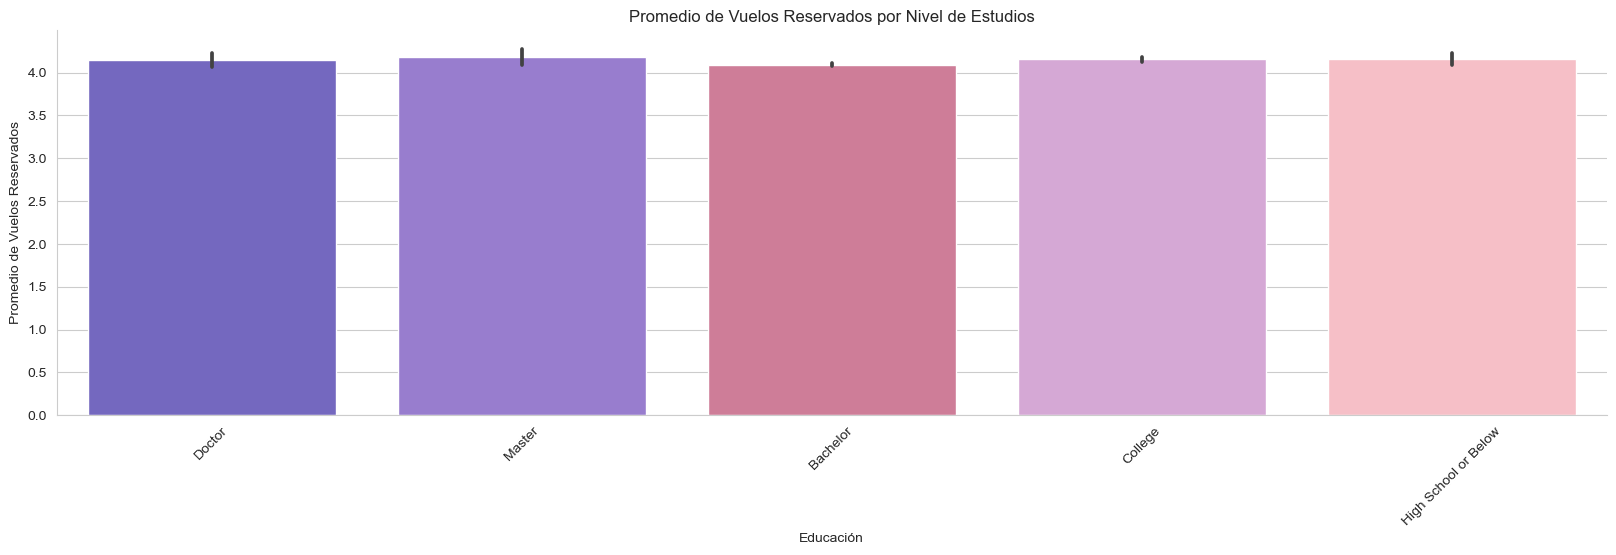

In [6]:
#Creo nuevas columnas por nivel educativo.
df_test['Doctor'] = df_test[df_test['Education'] == 'Doctor']['Flights_Booked'].astype(int)
df_test['Master'] = df_test[df_test['Education'] == 'Master']['Flights_Booked'].astype(int)
df_test['Bachelor'] = df_test[df_test['Education'] == 'Bachelor']['Flights_Booked'].astype(int)
df_test['College'] = df_test[df_test['Education'] == 'College']['Flights_Booked'].astype(int)
df_test['High_School'] = df_test[df_test['Education'] == 'High School or Below']['Flights_Booked'].astype(int)

#Visualizo los datos promedio con un barplot.
sns.set_style("whitegrid")

orden = ['Doctor', 'Master', 'Bachelor', 'College', 'High School or Below']
colores = ['slateblue', 'mediumpurple', 'palevioletred', 'plum', 'lightpink']

plt.figure(figsize=(20, 5))
sns.barplot(x='Education', y='Flights_Booked', data=df_test, palette=colores, order=orden, estimator=np.mean)
plt.xlabel('Educación')
plt.ylabel('Promedio de Vuelos Reservados')
plt.title('Promedio de Vuelos Reservados por Nivel de Estudios')
plt.xticks(rotation=45)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

**Observaciones** El gráfico de barras evidencia la diferencia del promedio del grupo Bachelor frente al resto pero no resulta concluyente. Se continuan realizando pruebas adicionales que aporten más información.

3. **Prueba Estadística:** Realiza una prueba de hipótesis para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

Planteo las hipótesis sobre el número de vuelos reservados en función del nivel educativo:

    - **Hipótesis Nula (H0):** No hay diferencia en el número de reservas de vuelos entre las personas con distintos niveles educativos.
    - **Hipótesis Nula (H1):** Hay una diferencia en el número de reservas de vuelos entre las personas con distintos niveles educativos.

In [7]:
#Antes de realizar la prueba de hipótesis, creo la función para aplicar el test de SHAPIRO-WILK y comprobar la normalidad de la distribución de cada grupo.
def normalidad(data, columna):
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"Para la columna '{columna}', los datos de vuelos reservados siguen una distribución normal (p-value: {p_value:.4f})."
    else:
        return f"Para la columna '{columna}', los datos de vuelos reservados no siguen una distribución normal (p-value: {p_value:.4f})."

#Creo una lista de las columnas a evaluar.
columnas = ['Doctor', 'Master', 'Bachelor', 'College', 'High_School']

#Itero sobre cada columna y aplico la función normalidad.
for columna in columnas:
    vuelos_grupo = df_test[columna].dropna()
    resultado_normalidad = normalidad(vuelos_grupo, columna)
    print(resultado_normalidad)

Para la columna 'Doctor', los datos de vuelos reservados no siguen una distribución normal (p-value: 0.0000).
Para la columna 'Master', los datos de vuelos reservados no siguen una distribución normal (p-value: 0.0000).
Para la columna 'Bachelor', los datos de vuelos reservados no siguen una distribución normal (p-value: 0.0000).
Para la columna 'College', los datos de vuelos reservados no siguen una distribución normal (p-value: 0.0000).
Para la columna 'High_School', los datos de vuelos reservados no siguen una distribución normal (p-value: 0.0000).


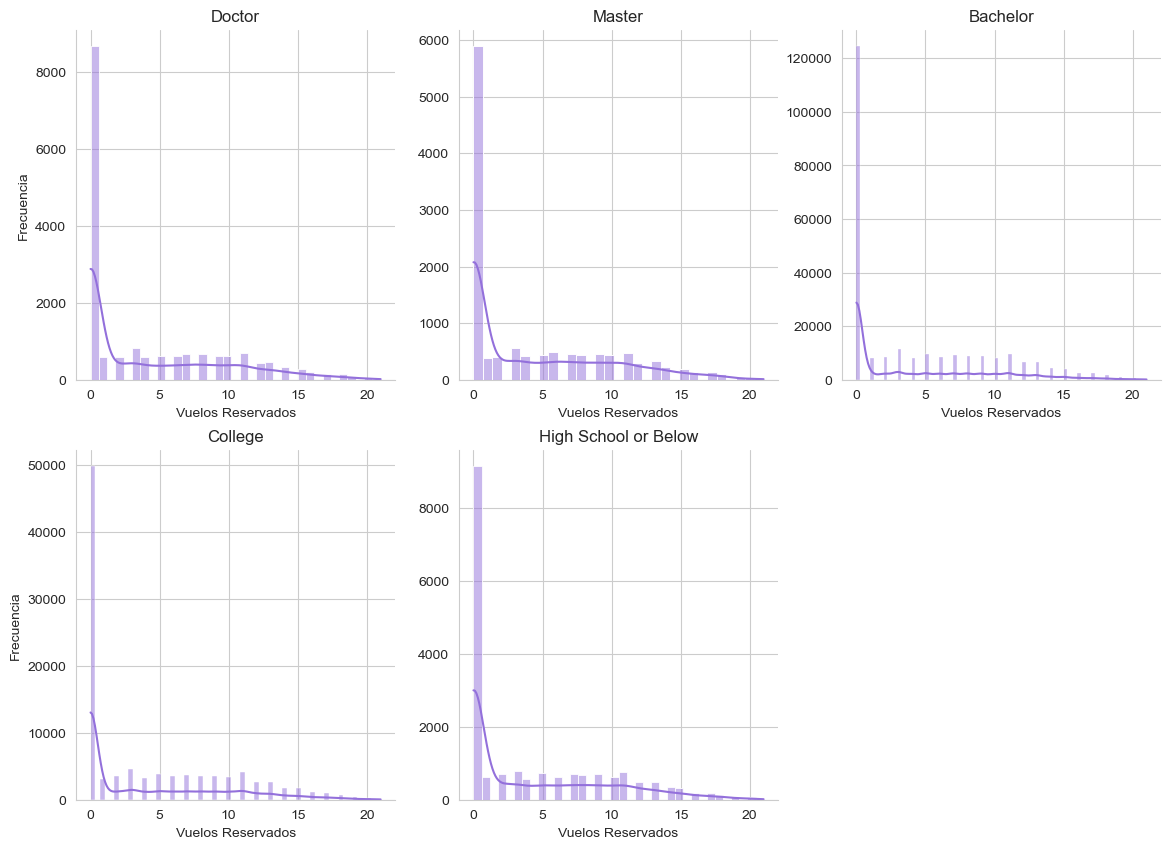

In [8]:
#Creo un histograma por cada grupo de análisis.
plt.figure(figsize=(14, 10))

#Doctor
plt.subplot(2, 3, 1)
sns.histplot(x='Doctor', data=df_test, kde=True, color='mediumpurple')
plt.title('Doctor')
plt.xlabel('Vuelos Reservados')
plt.ylabel('Frecuencia')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

#Master
plt.subplot(2, 3, 2)
sns.histplot(x='Master', data=df_test, kde=True, color='mediumpurple')
plt.title('Master')
plt.xlabel('Vuelos Reservados')
plt.ylabel('')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

#Bachelor
plt.subplot(2, 3, 3)
sns.histplot(x='Bachelor', data=df_test, kde=True, color='mediumpurple')
plt.title('Bachelor')
plt.xlabel('Vuelos Reservados')
plt.ylabel('')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

#College
plt.subplot(2, 3, 4)
sns.histplot(x='College', data=df_test, kde=True, color='mediumpurple')
plt.title('College')
plt.xlabel('Vuelos Reservados')
plt.ylabel('Frecuencia')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

#High_School
plt.subplot(2, 3, 5)
sns.histplot(x='High_School', data=df_test, kde=True, color='mediumpurple')
plt.title('High School or Below')
plt.xlabel('Vuelos Reservados')
plt.ylabel('')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

**Observaciones** Las gráficas confirman el resultado del test SHAPIRO-WILK, evidenciando que en ninguno de los cinco grupos de análisis los datos siguen una distribución normal o gaussiana.

In [9]:
#Creo la función para comprobar la homogeneidad de las varianzas aplicando el test de LEVENE.
def homogeneidad(dataframe, columna, columna_metrica):
    #Creo una lista para almacenar los datos de cada grupo.
    valores_evaluar = []
    
    for valor in dataframe[columna].unique():
        datos_grupo = dataframe[dataframe[columna] == valor][columna_metrica]
        valores_evaluar.append(datos_grupo)
    
    statistic, p_value = stats.levene(*valores_evaluar)
    
    if p_value > 0.05:
        print(f"Para la métrica '{columna_metrica}', las varianzas son homogéneas entre grupos.")
    else:
        print(f"Para la métrica '{columna_metrica}', las varianzas no son homogéneas entre grupos.")

#Defino los grupos o columnas que se evaluarán
grupos = ['Doctor', 'Master', 'Bachelor', 'College', 'High_School']

#Itero sobre cada grupo y llamo a la función homogeneidad.
for grupo in grupos:
    homogeneidad(df_test, 'Education', grupo)

Para la métrica 'Doctor', las varianzas no son homogéneas entre grupos.
Para la métrica 'Master', las varianzas no son homogéneas entre grupos.
Para la métrica 'Bachelor', las varianzas no son homogéneas entre grupos.
Para la métrica 'College', las varianzas no son homogéneas entre grupos.
Para la métrica 'High_School', las varianzas no son homogéneas entre grupos.


**Observaciones** Dado que los datos de los grupos de análisis no siguen una distribución normal y sus varianzas no son homogéneas, se realiza una prueba no paramétrica para confirmar o descartar las hipótesis planteadas al inicio del bloque o fase 3. Dado que se necesitan analizar cinco grupos, se opta por realizar la prueba de KRUSKAL-WALLIS.

In [10]:
#Importo la librería que necesito para realizar la prueba de KRUSKAL-WALLIS.
from scipy.stats import kruskal

#Guardo los datos filtrados de cada grupo en una variable.
doctor= df_test['Doctor'] = df_test[df_test['Education'] == 'Doctor']['Flights_Booked'].astype(int)
master= df_test['Master'] = df_test[df_test['Education'] == 'Master']['Flights_Booked'].astype(int)
bachelor= df_test['Bachelor'] = df_test[df_test['Education'] == 'Bachelor']['Flights_Booked'].astype(int)
college= df_test['College'] = df_test[df_test['Education'] == 'College']['Flights_Booked'].astype(int)
high_school= df_test['High_School'] = df_test[df_test['Education'] == 'High School or Below']['Flights_Booked'].astype(int)

statistic, p_value = kruskal(doctor, master, bachelor, college, high_school)

if p_value < 0.05:
    print(f"Existe una diferencia significativa entre al menos uno de los grupos (p-value: {p_value:.4f}).")
    print(f'Descartamos la Hipótesis Nula(H0)')
else:
    print(f"No se encontró una diferencia significativa entre los grupos (p-value: {p_value:.4f}).")
    print(f'No podemos descartar la Hipótesis Nula (H0).')

Existe una diferencia significativa entre al menos uno de los grupos (p-value: 0.0012).
Descartamos la Hipótesis Nula(H0)


### Conclusiones
**Los resultados sugieren que existe evidencia estadística para afirmar que el número de vuelos reservado por grupos es distinto.** Por lo tanto inferimos, a pesar de la similitud de las medianas y los percentiles, que el número de vuelos reservados varía según el nivel educativo de los clientes.  

De todos modos y con la intención de ampliar y terminar de confirmar los resultados del análisis **se recomienda incluir otras variables como el salario, las prestaciones de las distintas tarjetas de fidelización, o tratar de inferir los datos de columnas como Cancellation Year o Cancellation Month** (los datos están presentes en el .csv *Customer Loyalty History* pero presentan muchos nulos), para determinar si esta ausencia de reservas se debe a que esos clientes ya no forman parte del programa de fidelización.

**También es importante resaltar que el tamaño de la muestra varía notablemente de un grupo a otro**, puesto que el número de clientes que poseen una titulación superior como un máster o un doctorado es mucho menor que el resto. Esto puede explicar por qué el conteo de los vuelos reservados por los grupos Bachelor, College y High School or Below es mucho mayor que el de los dos niveles educativos superiores (Doctor y Máster), y que a su vez, las medidas descriptivas (como medias, medianas, desviaciones y percentiles), sean similares o practicamente idénticas.